In [1]:
import numpy as np
import scipy.sparse
from pathlib import Path
import matplotlib.pylab as plt
import seaborn as sns
import random
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tensorflow.keras.utils import to_categorical

In [2]:
def get_data(file):
    matrix = scipy.sparse.load_npz(file).todense()
    return np.array(matrix).reshape(1000, 8, 8, 40)

In [3]:
# file starting with b are signal, e for background
folder = Path("./data")

data_sig_l = []
data_bkg_l = []
for file in folder.iterdir():
    # signal files
    is_signal = file.name[0] == "b"
    is_background = file.name[0] == "e"
    if is_signal:
        if file.suffix == ".npz":
            data_sig_l.append(get_data(file))
    # background files
    elif is_background:
        if file.suffix == ".npz":
            data_bkg_l.append(get_data(file))

data_sig_l = np.concatenate(data_sig_l, axis=0)
data_bkg_l = np.concatenate(data_bkg_l, axis=0)

print(f"Signal shapes data: {data_sig_l.shape}")
print(f"Background shapes data: {data_bkg_l.shape}")

Signal shapes data: (10000, 8, 8, 40)
Background shapes data: (10000, 8, 8, 40)


Plotting number 6337


<Figure size 3600x7200 with 0 Axes>

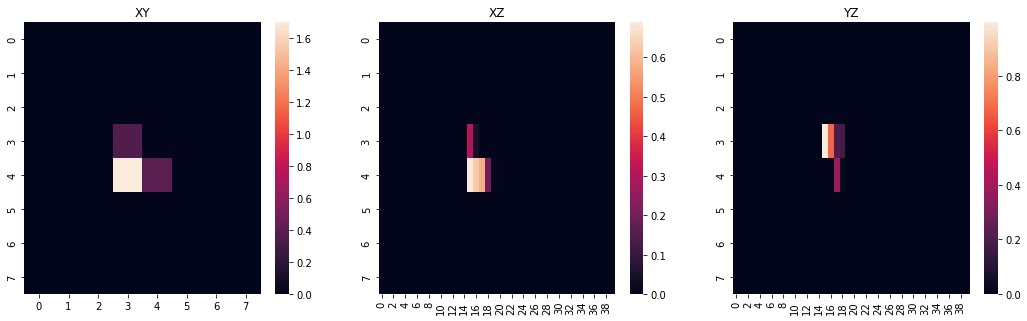

In [4]:
# Plot of a random event
plt.figure(figsize=(50, 100))
fig, (axs) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(18)

n = random.randrange(0, 1e4) 
is_sig = False
if is_sig:
    dataZ = data_sig_l.sum(3)
    dataY = data_sig_l.sum(2)
    dataX = data_sig_l.sum(1)
else:
    dataZ = data_bkg_l.sum(3)
    dataY = data_bkg_l.sum(2)
    dataX = data_bkg_l.sum(1)

print("Plotting number", n)
gz = sns.heatmap(dataZ[n], annot=False, ax=axs[0])
gz.set_title("XY")

gy = sns.heatmap(dataY[n], annot=False, ax=axs[1])
gy.set_title("XZ")

gx = sns.heatmap(dataX[n], annot=False, ax=axs[2])
gx.set_title("YZ")


plt.show()

In [5]:
# Extracting only energies from 3D hits
# nmax = 17 -> 17 features per event (with 0 padding for missing hits)
def build_features_e(data):
    nmax = 17 # max number of hits encountered
    feats = np.zeros((nmax+1, data.shape[0]))-1
    for i, particle in enumerate(data):
        coords = np.argwhere(particle)   
        n = coords.shape[0]

        en = np.zeros(n)
        en = particle[coords[:, 0], coords[:, 1], coords[:, 2]]

        z = np.zeros(nmax-n)
        feats[:-1, i] = np.concatenate((en, z))
        feats[-1, i] = n

    return feats

In [6]:
# Extracting energies and coordinates from 3D hits
# nmax = 17 -> 17*4 features per event (with 0 padding for missing hits)
def build_features_ec(data):
    nmax = 17 # max number of hits encountered
    feats = np.zeros((4*nmax+1, data.shape[0]))-1
    for i, particle in enumerate(data):
        coords = np.argwhere(particle)
        n = coords.shape[0]

        if n != 0:
            cx = coords[:,0]-coords[0,0]
            cy = coords[:,1]-coords[0,1]
            cz = coords[:,2]-coords[0,2]
            z = np.zeros(nmax-n)

            en = particle[coords[:, 0], coords[:, 1], coords[:, 2]] 

            feats[:nmax, i] = np.concatenate((en, z))
            feats[nmax:2*nmax, i] = np.concatenate((cx, z))
            feats[2*nmax:3*nmax, i] = np.concatenate((cy, z))
            feats[3*nmax:4*nmax, i] = np.concatenate((cz, z))
            feats[-1, i] = n

    return feats

In [7]:
# Extracting only energies from 2D projections (integrating over a chosen axis. Default: Z)
def build_features_e_2D(data3d, ax = 3):
    data = data3d.sum(ax)
    if ax == 3:
        nmax = 7 # max number of hits encountered
    else:
        nmax = 17
    feats = np.zeros((nmax+1, data.shape[0]))-1
    for i, particle in enumerate(data):

        coords = np.argwhere(particle > 0.05)
        n = coords.shape[0]
        if n != 0:
            z = np.zeros(nmax-n)
            en = np.zeros(n)  
            en = particle[coords[:,0], coords[:,0]]
            feats[:nmax, i] = np.concatenate((en, z))
            feats[-1, i] = n

    return feats

In [8]:
# Extracting energies and coordinates from 2D projections (integrating over a chosen axis. Default: Z)
def build_features_ec_2D(data3d, ax = 3):
    data = data3d.sum(ax)
    if ax == 3:
        nmax = 7 # max number of hits encountered
    else:
        nmax = 17
    feats = np.zeros((3*nmax+1, data.shape[0]))-1
    for i, particle in enumerate(data):
        coords = np.argwhere(particle > 0.05)
        n = coords.shape[0]
        if n != 0:
            if n > 8:
                print(i)
            cx = coords[:,0]-coords[0,0]
            cy = coords[:,1]-coords[0,1]
            z = np.zeros(nmax-n)

            en = particle[coords[:,0], coords[:,0]]

            feats[:nmax, i] = np.concatenate((en, z))
            feats[nmax:2*nmax, i] = np.concatenate((cx, z))
            feats[2*nmax:3*nmax, i] = np.concatenate((cy, z))
            feats[-1, i] = n

    return feats

In [9]:
# Computing the features
feats_sig_e = build_features_e(data_sig_l)
feats_bkg_e = build_features_e(data_bkg_l)
feats_sig_ec = build_features_ec(data_sig_l)
feats_bkg_ec = build_features_ec(data_bkg_l)
feats_sig_e_2D = build_features_e_2D(data_sig_l)
feats_bkg_e_2D = build_features_e_2D(data_bkg_l)
feats_sig_ec_2D = build_features_ec_2D(data_sig_l)
feats_bkg_ec_2D = build_features_ec_2D(data_bkg_l)

F_sig = [feats_sig_e, feats_sig_ec, feats_sig_e_2D, feats_sig_ec_2D]
F_bkg = [feats_bkg_e, feats_bkg_ec, feats_bkg_e_2D, feats_bkg_ec_2D]

<Figure size 5040x8640 with 0 Axes>

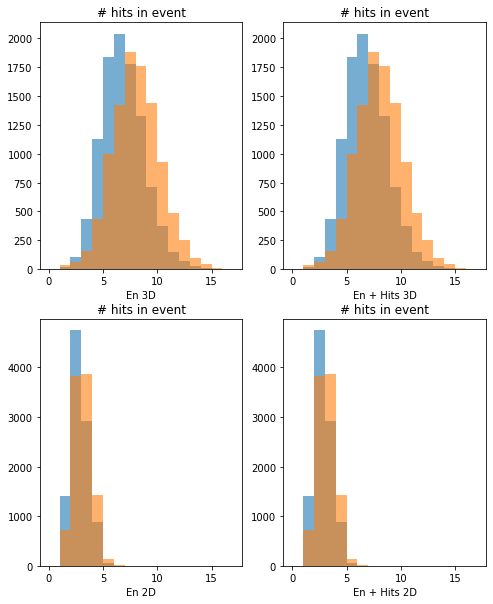

In [10]:
# Plotting the last feature for each of the 4 methods, which is the number of hits
ncols = 2
nrows = 2

plt.figure(figsize=(70, 120))
fig, (axs) = plt.subplots(nrows, ncols)
fig.set_figheight(10)
fig.set_figwidth(8)

xlabels = ['En 3D', 'En + Hits 3D', 'En 2D', 'En + Hits 2D']
for i in range(ncols):
    for j in range(nrows):
        ij = i * ncols + j
        if ij == 4:
            break
        axs[i, j].hist(F_sig[ij][-1], alpha=0.6, bins = 17, range = [0,17])
        axs[i, j].hist(F_bkg[ij][-1], alpha = 0.6, bins = 17, range = [0,17])
        axs[i, j].set_title("# hits in event")
        axs[i, j].set_xlabel(xlabels[ij])

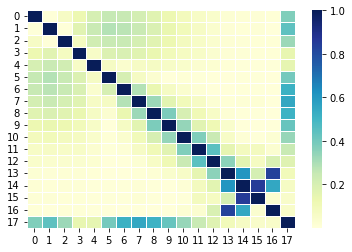

In [11]:
# Linear correlation (Pearson) matrix
corr = np.corrcoef((F_sig[0]))

ax = sns.heatmap(np.abs(corr), linewidth=0.5, cmap="YlGnBu")
plt.show()

In [12]:
# Feature selection based on Gini index
def RFselection(str, ltr, ste, nfeats):
    model = RandomForestRegressor(random_state=1, max_depth=10)
    model.fit(str, ltr)
    importances = model.feature_importances_
    indices = np.argsort(importances)[-nfeats:]

    str = str[:, indices]
    ste = ste[:, indices]
    #feature = SelectFromModel(model) 
    return str, ste

In [13]:
# Train and test splitting, training and testing the SVM
# No evidence of improvements when including coordinates features

r = np.arange(0, 20000)
train_idx = np.array(random.sample(range(20000), 1000))
test_idx = np.delete(r, train_idx)

speech = [' 3D En        ', ' 3D En+coords ', ' 2D En        ', ' 2D En+coords ']
classical_kernels = ["linear", "poly", "rbf"]#, "sigmoid"]
for i in range(0, 4):
    
    data = np.concatenate([F_sig[i], F_bkg[i]], axis=1).T
    scaler = MinMaxScaler()
    scaler.fit(data)
    data = scaler.transform(data)
    labels = np.concatenate((np.ones(10000), np.zeros(10000)))
    
    sample_train = data[train_idx]
    label_train = labels[train_idx]
    sample_test = data[test_idx]
    label_test = labels[test_idx]

    do_RFselection = False # True = selection with Gini index
    do_PCA = True # Probably not the best choice for feature reduction
    if do_RFselection:
        nfeats = 7
        sample_train, sample_test = RFselection(sample_train, label_train,
                                                sample_test, nfeats)
    if do_PCA:
        n_dim = 7
        pca = PCA(n_components=n_dim).fit(sample_train)
        sample_train = pca.transform(sample_train)
        sample_test = pca.transform(sample_test)

    for kernel in classical_kernels:
        classical_svc = SVC(kernel=kernel)
        classical_svc.fit(sample_train, label_train)
        classical_score = classical_svc.score(sample_test, label_test)

        print("%s %s kernel test score:  %0.4f" % (speech[i], kernel, classical_score))

 3D En         linear kernel test score:  0.6009
 3D En         poly kernel test score:  0.5989
 3D En         rbf kernel test score:  0.6258
 3D En+coords  linear kernel test score:  0.5994
 3D En+coords  poly kernel test score:  0.6022
 3D En+coords  rbf kernel test score:  0.6223
 2D En         linear kernel test score:  0.5723
 2D En         poly kernel test score:  0.5521
 2D En         rbf kernel test score:  0.5517
 2D En+coords  linear kernel test score:  0.5768
 2D En+coords  poly kernel test score:  0.5533
 2D En+coords  rbf kernel test score:  0.5633


In [14]:
# CNN approach
# CNN is the best so far (not using raw entries but the 2D XZ and YZ views as 'images')

data_sigY = np.expand_dims(data_sig_l.sum(2), 3)
data_bkgY = np.expand_dims(data_bkg_l.sum(2), 3)

data_sigX = np.expand_dims(data_sig_l.sum(1), 3)
data_bkgX = np.expand_dims(data_bkg_l.sum(1), 3)

dataYX_sig = np.concatenate([data_sigY, data_sigX], axis=3)
dataYX_bkg = np.concatenate([data_bkgY, data_bkgX], axis=3)
data = np.concatenate([dataYX_bkg, dataYX_sig], axis=0)

labels = np.concatenate([np.zeros(dataYX_bkg.shape[0]), np.ones(dataYX_sig.shape[0])])

sample_train, sample_test, label_train, label_test = train_test_split(
    data, labels, test_size=0.2, train_size=0.8
)
label_train = to_categorical(label_train)
label_test = to_categorical(label_test)
print(f"Train: data of shape {sample_train.shape}, labels of shape {label_train.shape}")
print(f"Test: data of shape {sample_test.shape}, labels of shape {label_test.shape}")

Train: data of shape (16000, 8, 40, 2), labels of shape (16000, 2)
Test: data of shape (4000, 8, 40, 2), labels of shape (4000, 2)


In [15]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU

# CNN architecture

batch_size = 600
epochs = 20
num_classes = 2
learning_rate = 0.05

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(8, 40, 2), padding="same"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(12, kernel_size=(3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Flatten())
model.add(Dense(3))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(num_classes, activation="softmax"))

model.compile(
    loss=categorical_crossentropy, optimizer=Adam(learning_rate), metrics=["accuracy"]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 40, 32)         608       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 40, 32)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 20, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 18, 12)         3468      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 2, 18, 12)         0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 9, 12)         0         
 2D)                                                    

In [16]:
train = model.fit(
    sample_train, label_train, batch_size=batch_size, epochs=epochs, verbose=1
)

Epoch 1/20
27/27 [==============================] - 3s 100ms/step - loss: 0.6593 - accuracy: 0.6072
Epoch 2/20
27/27 [==============================] - 3s 103ms/step - loss: 0.6306 - accuracy: 0.6491
Epoch 3/20
27/27 [==============================] - 3s 105ms/step - loss: 0.6171 - accuracy: 0.6587
Epoch 4/20
27/27 [==============================] - 3s 118ms/step - loss: 0.6072 - accuracy: 0.6734
Epoch 5/20
27/27 [==============================] - 3s 98ms/step - loss: 0.5972 - accuracy: 0.6842
Epoch 6/20
27/27 [==============================] - 3s 101ms/step - loss: 0.5979 - accuracy: 0.6817
Epoch 7/20
27/27 [==============================] - 3s 107ms/step - loss: 0.5956 - accuracy: 0.6822
Epoch 8/20
27/27 [==============================] - 3s 103ms/step - loss: 0.5783 - accuracy: 0.6965
Epoch 9/20
27/27 [==============================] - 3s 111ms/step - loss: 0.5768 - accuracy: 0.6970
Epoch 10/20
27/27 [==============================] - 3s 112ms/step - loss: 0.5652 - accuracy: 0.7060


In [17]:
# Evaluating performances on test set
test_eval = model.evaluate(sample_test, label_test, verbose=0)
print("Test loss:", test_eval[0])
print("Test accuracy:", test_eval[1])

Test loss: 0.5964741706848145
Test accuracy: 0.6819999814033508


In [28]:
# Last approach: 'heuristic'. Features based on the underlying physics assumptions
def build_features(data):
    feats = np.zeros((17, data.shape[0]))-1
    for i, particle in enumerate(data):
        coords = np.argwhere(particle)
        n = coords.shape[0]
        if n != 0:
            n = coords.shape[0]
            en = np.zeros(n)  
            for j in range(0, n):
                en[j] = particle[coords[j,0], coords[j, 1], coords[j, 2]]
            feats[0, i] = coords.shape[0]
            feats[1, i] = np.sqrt((coords[0, 0] - coords[-1,0])**2 + 
                                  (coords[0, 1] - coords[-1, 1])**2 + 
                                  (coords[0, 2] - coords[-1, 2])**2)/coords.shape[0]
            feats[2, i] = (en[0] + en[-1])/np.sum(en)

            feats[3, i] = np.sum(en)
            feats[13, i] = np.log(1+en[round(n/2)]/en[0]/en[-1])
            feats[16, i] = np.amax(en)/n
            if n> 1:
                feats[14, i] = np.log(1+en[round(n/2)]/en[1]/en[-2])
                feats[8, i] = (en[1] + en[-2])/np.sum(en)
                feats[4, i] = np.abs(np.amax(np.diff(en))/np.sum(en))
            if n > 3:
                feats[9, i] = en[round(n/2)]/np.sum(en)
                feats[5, i] = np.abs(en[0]+en[1] - en[-1]-en[-2])/np.sum(en)
                feats[6, i] = np.sqrt((coords[1, 0] - coords[-2,0])**2 + 
                                      (coords[1, 1] - coords[-2, 1])**2 + 
                                      (coords[1, 2] - coords[-2, 2])**2)/coords.shape[0]
            if n > 5:
                feats[15, i] = en[round(n/2)] + en[round(n/2+2)] + en[round(n/2-2)]

                feats[10, i] = np.abs(en[2]+en[1] - en[-3]-en[-2])/np.sum(en)
                feats[7, i] = np.sqrt((coords[2, 0] - coords[-3,0])**2 + 
                                      (coords[2, 1] - coords[-3, 1])**2 + 
                                      (coords[2, 2] - coords[-3, 2])**2)/coords.shape[0]
            if n > 6:
                feats[11, i] = np.abs(en[2]+en[3] - en[-3]-en[-4])/np.sum(en)
            if n > 7:
                feats[12, i] = np.abs(en[4]+en[3] - en[-5]-en[-4])/np.sum(en)
#     feats[-3,:] = np.log(0.1+feats[-3,:])
#     feats[-4,:] = np.log(0.1+feats[-4,:])
    return feats

In [29]:
feats_sig = build_features(data_sig_l)
feats_bkg = build_features(data_bkg_l)

<Figure size 3600x7200 with 0 Axes>

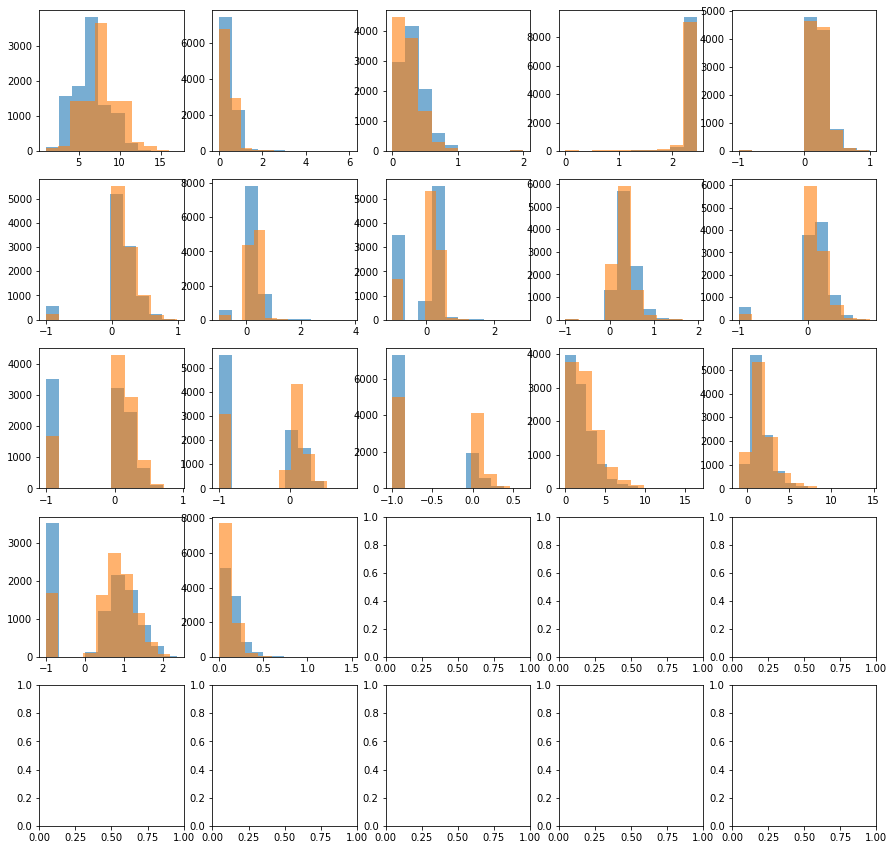

In [30]:
ncols = 5
nrows = 5

plt.figure(figsize=(50, 100))
fig, (axs) = plt.subplots(nrows, ncols)
fig.set_figheight(15)
fig.set_figwidth(15)

ij = 0
for i in range(ncols):
    if ij == 17:
        break
    for j in range(nrows):
        ij = i * ncols + j
        if ij == 17:
            break
        axs[i, j].hist(feats_sig[ij], alpha=0.6)
        axs[i, j].hist(feats_bkg[ij], alpha = 0.6)

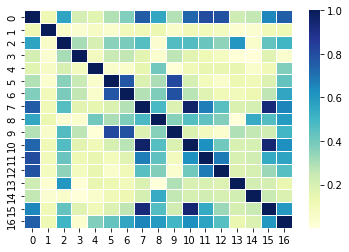

In [31]:
corr = np.corrcoef(list(feats_sig))

ax = sns.heatmap(np.abs(corr), linewidth=0.5, cmap="YlGnBu")
plt.show()

In [32]:
data = np.concatenate([feats_sig, feats_bkg], axis=1).T
labels = np.concatenate((np.ones(feats_sig.shape[1]), np.zeros(feats_bkg.shape[1])))

# Train and test splitting, training and testing the SVM
sample_train, sample_test, label_train, label_test = train_test_split(
    data, labels, test_size=0.9, train_size=0.1
)

# PCA with n_dim principal components
do_PCA = True
if do_PCA:
    n_dim = 10
    pca = PCA(n_components=n_dim).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

classical_kernels = ["linear", "poly", "rbf", "sigmoid"]

for kernel in classical_kernels:
    classical_svc = SVC(kernel=kernel)
    classical_svc.fit(sample_train, label_train)
    classical_score = classical_svc.score(sample_test, label_test)

    print("%s kernel classification test score:  %0.4f" % (kernel, classical_score))

linear kernel classification test score:  0.6295
poly kernel classification test score:  0.6166
rbf kernel classification test score:  0.6354
sigmoid kernel classification test score:  0.5473
